In [1]:
import pandas as pd
import os
import re
import sys
sys.path.append('/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages')
import sklearn
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.lines as mlines
from scipy import stats as st
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
result_header_df = pd.read_excel('../MMV living lab data/data_headers.xlsx')
headers = result_header_df.columns
headers

Index(['Timestamp', 'FCU-1 Cooling Load_kW', 'FCU-2 Cooling Load_kW',
       'FCU-3 Cooling Load_kW', 'FCU-4 Cooling Load_kW',
       'FCU-5 Cooling Load_kW', 'PFCU-1 Cooling Load_kW',
       'PFCU-2 Cooling Load_kW', 'Outdoor Temperature', 'Outdoor Temp Ave',
       'Outdoor Humidity', 'Wind Speed', 'Wind Direction', 'Solar Radiation',
       'Zone 3 Temperature', 'Zone 3  CO2', 'Zone 4 Temperature', 'Zone 4 CO2',
       'Zone 5 Temperature', 'Zone 5 CO2 - S1', 'Zone 5 CO2 - S2',
       'Zone 1 Temperature', 'Zone 1  CO2 - S1', 'Zone 1  CO2 - S2',
       'Zone 2 Temperature', 'Zone 2 CO2', 'Zone 1 Ave CO2',
       'Z7 Windows Open Close Status', 'Z6 Windows Open Close Status',
       'Z5 Windows Open Close Status', 'Z1 Windows Open Close Status',
       'Z2 Windows Open Close Status', 'Z3 Windows Open Close Status'],
      dtype='object')

In [4]:
comp_df=pd.read_csv('ALL_bms.csv')

In [5]:
comp_df['Timestamp'] = pd.to_datetime(comp_df['date'])

In [6]:
comp_df.head()

,Unnamed: 0,date,FCU-01 Watt,FCU-1 Cooling Load_kW,FCU-01 KWh,FCU-01 CHW Supply Temp,FCU-01 CHW Return Temp,FCU-01 Return Air CO2 Level,FCU-01 Return Air Humi,FCU-01 Return Temp,...,FCU-4 Cooling Load_kW,FCU-04 CHW Return Temp,FCU-04 CHW Supply Temp,FCU-04 Return Air CO2 Level,FCU-04 Return Air Humi,FCU-04 RM Temp,FCU-04 Supply Air Flow Rate,FCU-04 Supply Air Humi,FCU-04 CHW Flow Rate,Timestamp
0,0,2024-03-13 08:39:00,238.524742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-13 08:39:00
1,1,2024-03-13 08:40:00,237.809601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-13 08:40:00
2,2,2024-03-13 08:41:00,237.418716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-13 08:41:00
3,3,2024-03-13 08:42:00,237.418716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-13 08:42:00
4,4,2024-03-13 08:43:00,236.533173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-13 08:43:00


In [7]:
comp_df[headers].isnull().sum()

Timestamp                            0
FCU-1 Cooling Load_kW            38467
FCU-2 Cooling Load_kW            19084
FCU-3 Cooling Load_kW            19070
FCU-4 Cooling Load_kW            19088
FCU-5 Cooling Load_kW            19083
PFCU-1 Cooling Load_kW           19069
PFCU-2 Cooling Load_kW           19041
Outdoor Temperature             155309
Outdoor Temp Ave                246584
Outdoor Humidity                 45095
Wind Speed                       28927
Wind Direction                   30545
Solar Radiation                 150842
Zone 3 Temperature               18143
Zone 3  CO2                      18129
Zone 4 Temperature               18157
Zone 4 CO2                       18136
Zone 5 Temperature               18162
Zone 5 CO2 - S1                  18136
Zone 5 CO2 - S2                  18136
Zone 1 Temperature               18162
Zone 1  CO2 - S1                 18128
Zone 1  CO2 - S2                 18129
Zone 2 Temperature               18160
Zone 2 CO2               

In [7]:
comp_df["Timestamp"] = pd.to_datetime(comp_df["Timestamp"]).dt.floor("T")

comp_df.set_index("Timestamp", inplace=True)

# Generate a complete range of timestamps at 1-minute intervals
full_range = pd.date_range(start=comp_df.index.min(), end=comp_df.index.max(), freq='1T')

# Reindex the DataFrame to this full range, filling missing times with NaN
df_full = comp_df.reindex(full_range)

# Optional: Rename the index back to 'Timestamp' and reset index
df_full.index.name = "Timestamp"
df_full.reset_index(inplace=True,drop=False)

In [11]:
df_full[headers].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345606 entries, 0 to 345605
Data columns (total 33 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Timestamp                     345606 non-null  datetime64[ns]
 1   FCU-1 Cooling Load_kW         246501 non-null  float64       
 2   FCU-2 Cooling Load_kW         265884 non-null  float64       
 3   FCU-3 Cooling Load_kW         265898 non-null  float64       
 4   FCU-4 Cooling Load_kW         265880 non-null  float64       
 5   FCU-5 Cooling Load_kW         265885 non-null  float64       
 6   PFCU-1 Cooling Load_kW        265899 non-null  float64       
 7   PFCU-2 Cooling Load_kW        265927 non-null  float64       
 8   Outdoor Temperature           129659 non-null  float64       
 9   Outdoor Temp Ave              38384 non-null   float64       
 10  Outdoor Humidity              239873 non-null  float64       
 11  Wind Speed   

In [25]:
df_full[headers].isnull().sum()

Timestamp                            0
FCU-1 Cooling Load_kW            99105
FCU-2 Cooling Load_kW            79722
FCU-3 Cooling Load_kW            79708
FCU-4 Cooling Load_kW            79726
FCU-5 Cooling Load_kW            79721
PFCU-1 Cooling Load_kW           79707
PFCU-2 Cooling Load_kW           79679
Outdoor Temperature             215947
Outdoor Temp Ave                307222
Outdoor Humidity                105733
Wind Speed                       89565
Wind Direction                   91183
Solar Radiation                 211480
Zone 3 Temperature               78781
Zone 3  CO2                      78767
Zone 4 Temperature               78795
Zone 4 CO2                       78774
Zone 5 Temperature               78800
Zone 5 CO2 - S1                  78774
Zone 5 CO2 - S2                  78774
Zone 1 Temperature               78800
Zone 1  CO2 - S1                 78766
Zone 1  CO2 - S2                 78767
Zone 2 Temperature               78798
Zone 2 CO2               

In [26]:
df_full = df_full.sort_values(by='Timestamp')

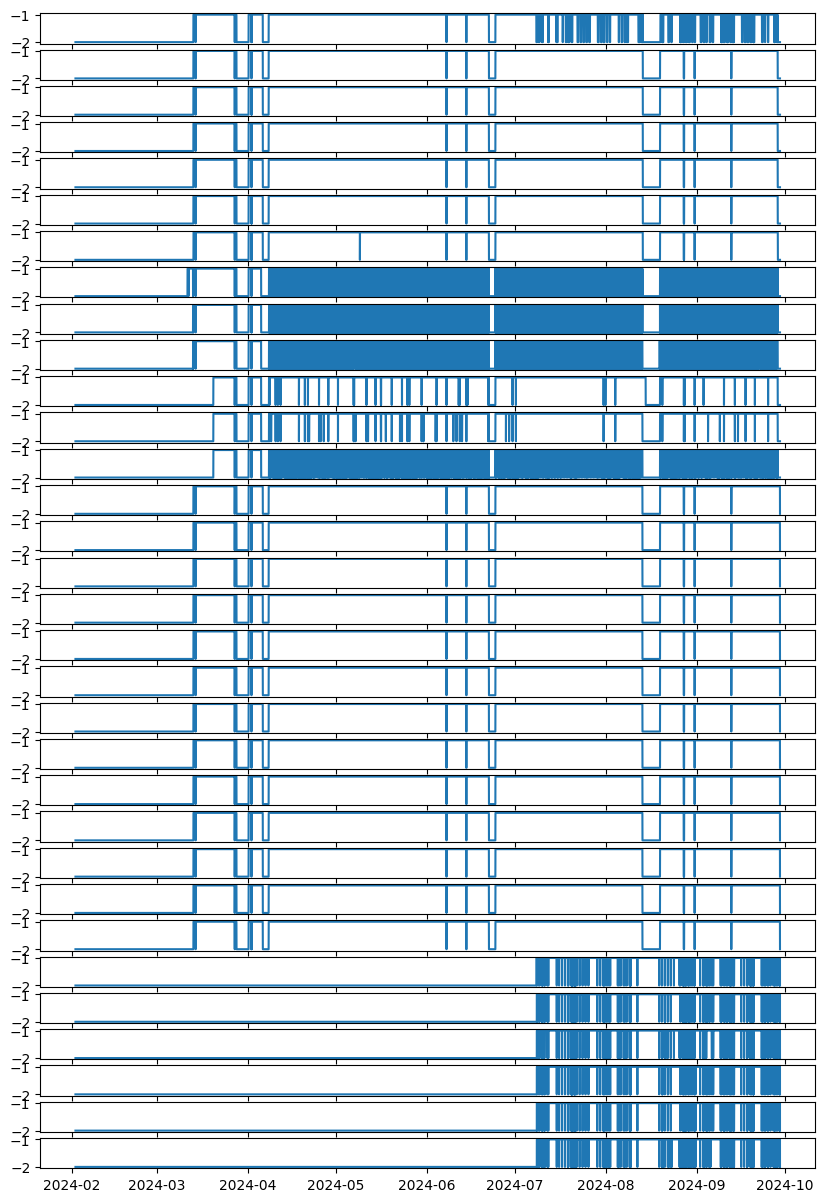

In [27]:
fig , ax = plt.subplots(len(headers)-1,figsize=(10, 15),sharex=True, sharey=True)

for i in range(0,len(headers)-1):
        
    ax[i].plot(df_full[headers[0]],[int(~a) for a in df_full[headers[i+1]].isnull()])

In [42]:
pd.to_datetime('2024/5/1')

Timestamp('2024-05-01 00:00:00')

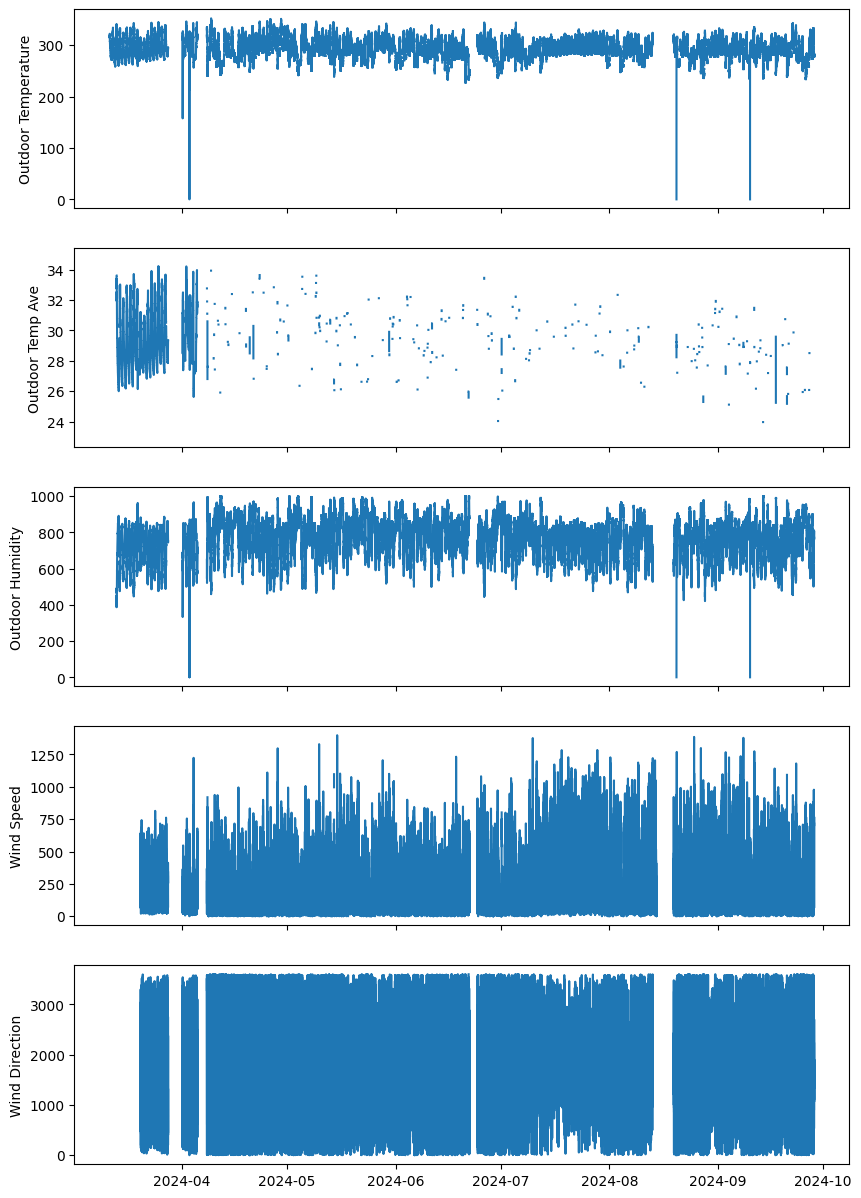

In [39]:
fig , ax = plt.subplots(5,figsize=(10, 15),sharex=True, sharey=False)

for i in range(8,13):
        
    ax[i-8].plot(df_full[headers[0]],df_full[headers[i]])
    ax[i-8].set_ylabel(headers[i])

In [43]:
df_full[[headers[0],headers[8]]].loc[(~df_full[headers[8]].isnull())&(df_full[headers[0]]>pd.to_datetime('2024/5/1'))]

,Timestamp,Outdoor Temperature
127876,2024-05-01 00:16:00,295.0
127878,2024-05-01 00:18:00,296.0
127879,2024-05-01 00:19:00,296.0
127880,2024-05-01 00:20:00,296.0
127881,2024-05-01 00:21:00,295.0
...,...,...
344453,2024-09-28 09:53:00,280.0
344455,2024-09-28 09:55:00,281.0
344456,2024-09-28 09:56:00,282.0
344458,2024-09-28 09:58:00,281.0


In [44]:
def fill_islands(df, col, max_gap=30, tolerance=0.10):
    data = df[col].copy()
    is_nan = data.isna()
    
    filled = data.copy()
    i = 0
    
    while i < len(data):
        if is_nan.iloc[i]:
            start = i
            while i < len(data) and is_nan.iloc[i]:
                i += 1
            end = i  # non-NaN starts again here
            
            gap_size = end - start
            #print(gap_size)
            
            if start > 0 and end < len(data) and gap_size < max_gap:
                val_before = data.iloc[start - 1]
                val_after = data.iloc[end]

                # Handle edge cases where before/after might still be NaN
                if pd.notna(val_before) and pd.notna(val_after):
                    if 'Open Close Status' in col:
                        if val_after == val_before:
                            filled.iloc[start:end] = val_before
                    elif val_before !=0:
                        if abs(val_after - val_before) / abs(val_before) <= tolerance:
                            filled.iloc[start:end] = val_before  # or use linear interpolation
                    else:
                        if abs(val_after - val_before)<2:
                            filled.iloc[start:end] = val_before  # or use linear interpolation
        else:
            i += 1
    return filled

In [50]:
new_df=pd.DataFrame()
new_df['Timestamp'] = df_full['Timestamp']
for col in headers[1:]:
    new_df[col] = fill_islands(df_full, col)

In [54]:
new_df.isnull().sum()

Timestamp                            0
FCU-1 Cooling Load_kW            98985
FCU-2 Cooling Load_kW            79687
FCU-3 Cooling Load_kW            79675
FCU-4 Cooling Load_kW            79685
FCU-5 Cooling Load_kW            79684
PFCU-1 Cooling Load_kW           79671
PFCU-2 Cooling Load_kW           79659
Outdoor Temperature              95318
Outdoor Temp Ave                229125
Outdoor Humidity                 80865
Wind Speed                       89436
Wind Direction                   91016
Solar Radiation                 206642
Zone 3 Temperature               78733
Zone 3  CO2                      78721
Zone 4 Temperature               78740
Zone 4 CO2                       78725
Zone 5 Temperature               78751
Zone 5 CO2 - S1                  78728
Zone 5 CO2 - S2                  78728
Zone 1 Temperature               78746
Zone 1  CO2 - S1                 78720
Zone 1  CO2 - S2                 78721
Zone 2 Temperature               78736
Zone 2 CO2               

In [56]:
df_full[headers].isnull().sum()-new_df.isnull().sum()

Timestamp                            0
FCU-1 Cooling Load_kW              120
FCU-2 Cooling Load_kW               35
FCU-3 Cooling Load_kW               33
FCU-4 Cooling Load_kW               41
FCU-5 Cooling Load_kW               37
PFCU-1 Cooling Load_kW              36
PFCU-2 Cooling Load_kW              20
Outdoor Temperature             120629
Outdoor Temp Ave                 78097
Outdoor Humidity                 24868
Wind Speed                         129
Wind Direction                     167
Solar Radiation                   4838
Zone 3 Temperature                  48
Zone 3  CO2                         46
Zone 4 Temperature                  55
Zone 4 CO2                          49
Zone 5 Temperature                  49
Zone 5 CO2 - S1                     46
Zone 5 CO2 - S2                     46
Zone 1 Temperature                  54
Zone 1  CO2 - S1                    46
Zone 1  CO2 - S2                    46
Zone 2 Temperature                  62
Zone 2 CO2               

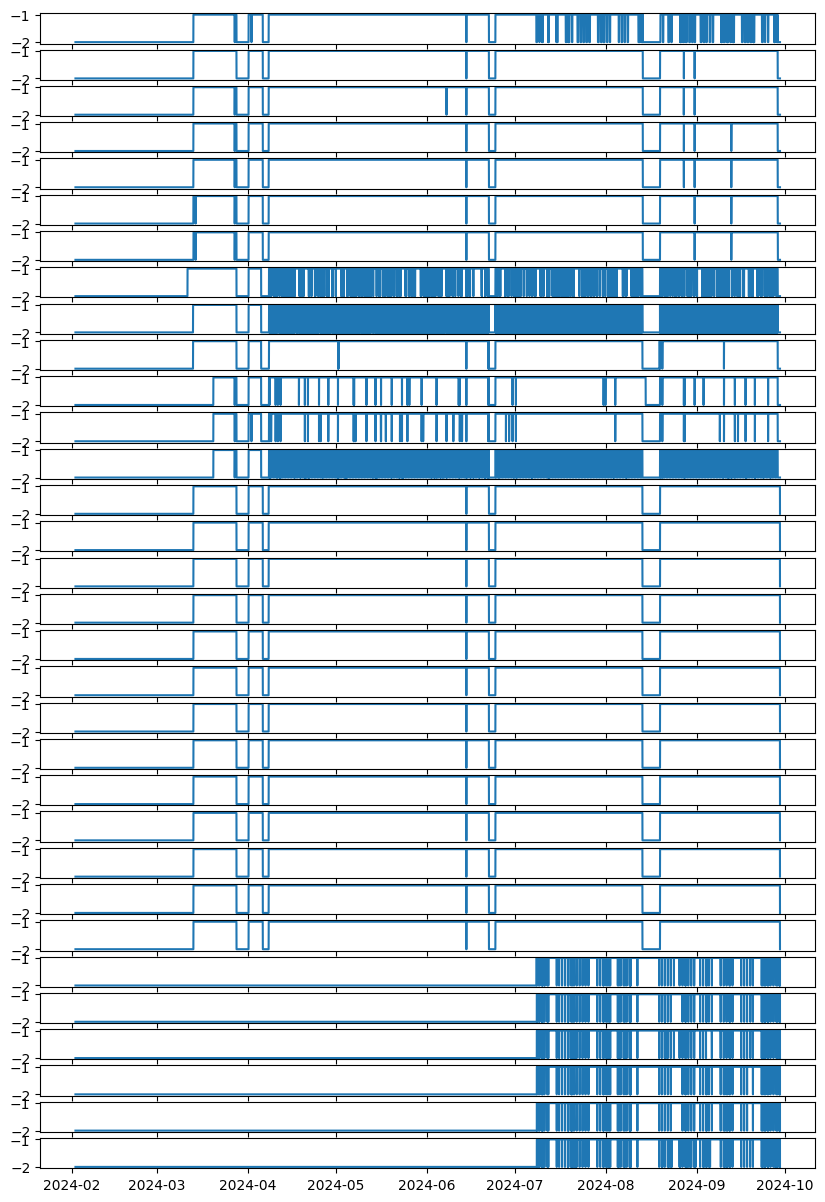

In [57]:
fig , ax = plt.subplots(len(headers)-1,figsize=(10, 15),sharex=True, sharey=True)

for i in range(0,len(headers)-1):
        
    ax[i].plot(new_df[headers[0]],[int(~a) for a in new_df[headers[i+1]].isnull()])

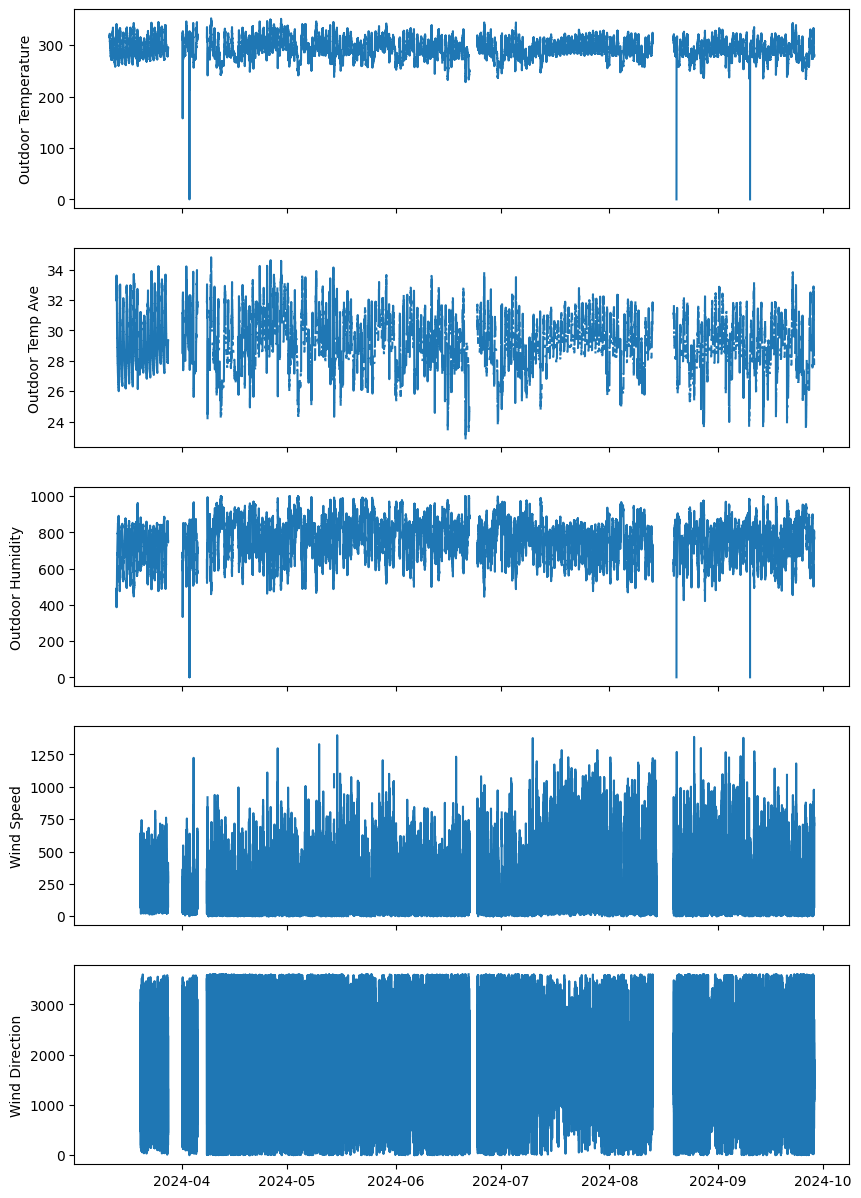

In [59]:
fig , ax = plt.subplots(5,figsize=(10, 15),sharex=True, sharey=False)

for i in range(8,13):
        
    ax[i-8].plot(new_df[headers[0]],new_df[headers[i]])
    ax[i-8].set_ylabel(headers[i])

In [ ]:
'''cooling load is to be manually calculated once we remove erroneous datapoints.'''


In [8]:
comp_df['FCU-1 thermal load'] = (comp_df['FCU-01 CHW Return Temp']-comp_df['FCU-01 CHW Supply Temp'])*comp_df['FCU-01 CHW Flow Rate']
comp_df['FCU-2 thermal load'] = (comp_df['FCU-02 CHW Return Temp']-comp_df['FCU-02 CHW Supply Temp'])*comp_df['FCU-02 CHW Flow Rate_x']
comp_df['FCU-3 thermal load'] = (comp_df['FCU-03 CHW Return Temp']-comp_df['FCU-03 CHW Supply Temp'])*comp_df['FCU-03 CHW Flow Rate']
comp_df['FCU-4 thermal load'] = (comp_df['FCU-04 CHW Return Temp']-comp_df['FCU-04 CHW Supply Temp'])*comp_df['FCU-04 CHW Flow Rate']
comp_df['FCU-5 thermal load'] = (comp_df['FCU-05 CHW Return Temp']-comp_df['FCU-05 CHW Supply Temp'])*comp_df['FCU-05 CHW Flow Rate']

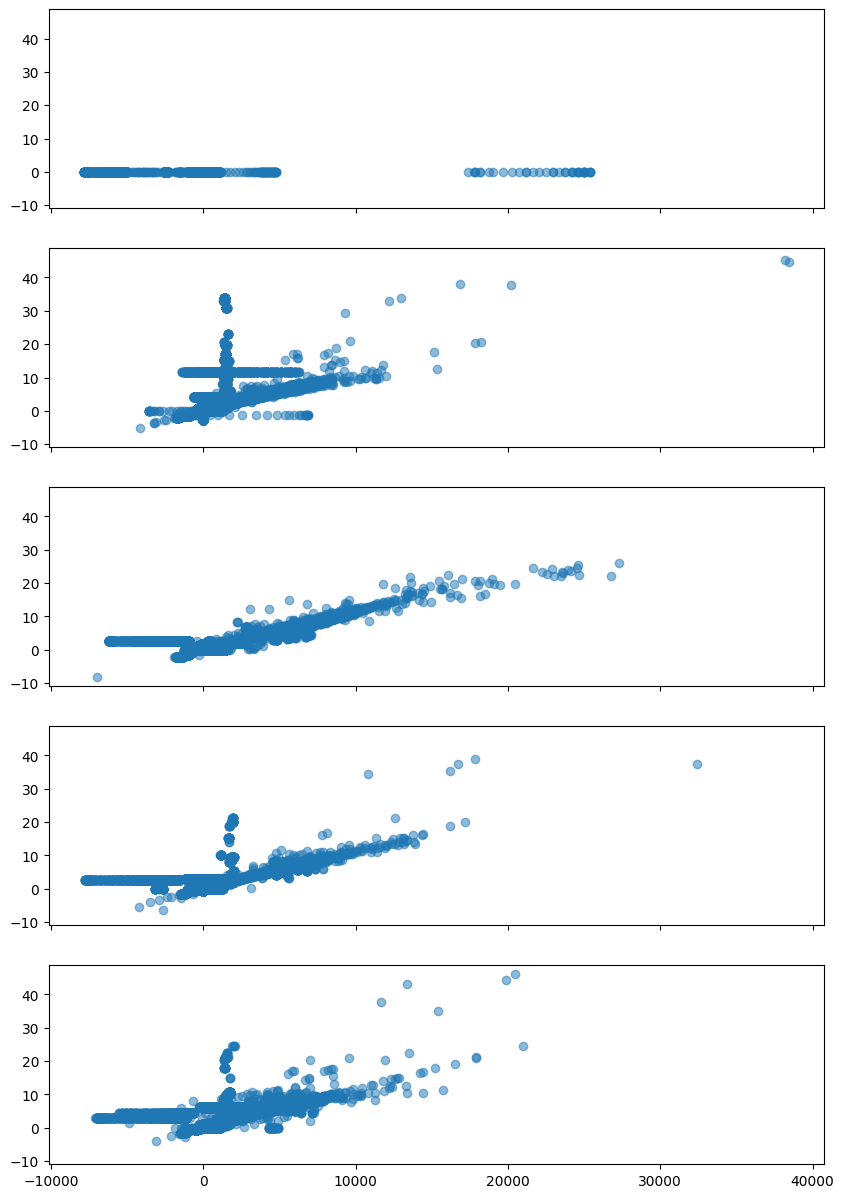

In [9]:
# --- Plot original data + line + outliers ---
fig , ax = plt.subplots(5,figsize=(10, 15),sharex=True, sharey=True)


# 1. Plot all data points
ax[0].scatter(comp_df['FCU-1 thermal load'], comp_df['FCU-1 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[1].scatter(comp_df['FCU-2 thermal load'], comp_df['FCU-2 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[2].scatter(comp_df['FCU-3 thermal load'], comp_df['FCU-3 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[3].scatter(comp_df['FCU-4 thermal load'], comp_df['FCU-4 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[4].scatter(comp_df['FCU-5 thermal load'], comp_df['FCU-5 Cooling Load_kW'], alpha=0.5, label="Data points")


In [22]:
comp_df[['FCU-1 thermal load','FCU-2 Cooling Load_kW']].values

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [23]:
X = np.concatenate([comp_df[['FCU-2 thermal load','FCU-2 Cooling Load_kW']].values, 
                    comp_df[['FCU-3 thermal load','FCU-3 Cooling Load_kW']].values, 
                    comp_df[['FCU-4 thermal load','FCU-4 Cooling Load_kW']].values, 
                    comp_df[['FCU-5 thermal load','FCU-5 Cooling Load_kW']].values], axis=0)

In [25]:
X.shape

(1139872, 2)

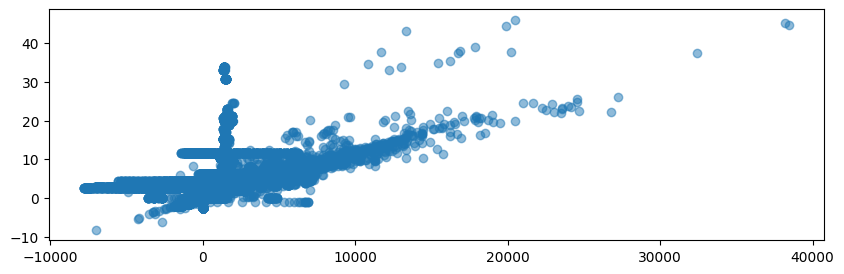

In [28]:
# --- Plot original data + line + outliers ---
fig , ax = plt.subplots(1,figsize=(10, 3),sharex=True, sharey=True)


# 1. Plot all data points
ax.scatter(X[:,0], X[:,1], alpha=0.5, label="Data points")



In [35]:
lens=[]
drop_vals=[]
for a in set(X[:,1]):
    if ~np.isnan(a):
        mask = X[:, 1] == a
        x0_subset = X[:, 0][mask]
        diff = np.max(x0_subset) - np.min(x0_subset)
        lens.append(len(x0_subset))
        if (len(x0_subset)>100)|(diff>7000):
            drop_vals.append(a)
drop_vals = np.array(drop_vals)

In [81]:
mask2 = np.isin(comp_df['FCU-2 Cooling Load_kW'],drop_vals)|(comp_df['FCU-2 Cooling Load_kW'].isnull())#|((comp_df['FCU-2 Cooling Load_kW']==0)&(comp_df['FCU-2 thermal load']!=0))
mask3 = np.isin(comp_df['FCU-3 Cooling Load_kW'],drop_vals)|(comp_df['FCU-3 Cooling Load_kW'].isnull())#|((comp_df['FCU-3 Cooling Load_kW']==0)&(comp_df['FCU-3 thermal load']!=0))
mask4 = np.isin(comp_df['FCU-4 Cooling Load_kW'],drop_vals)|(comp_df['FCU-4 Cooling Load_kW'].isnull())#|((comp_df['FCU-4 Cooling Load_kW']==0)&(comp_df['FCU-4 thermal load']!=0))
mask5 = np.isin(comp_df['FCU-5 Cooling Load_kW'],drop_vals)|(comp_df['FCU-5 Cooling Load_kW'].isnull())#|((comp_df['FCU-5 Cooling Load_kW']==0)&(comp_df['FCU-5 thermal load']!=0))


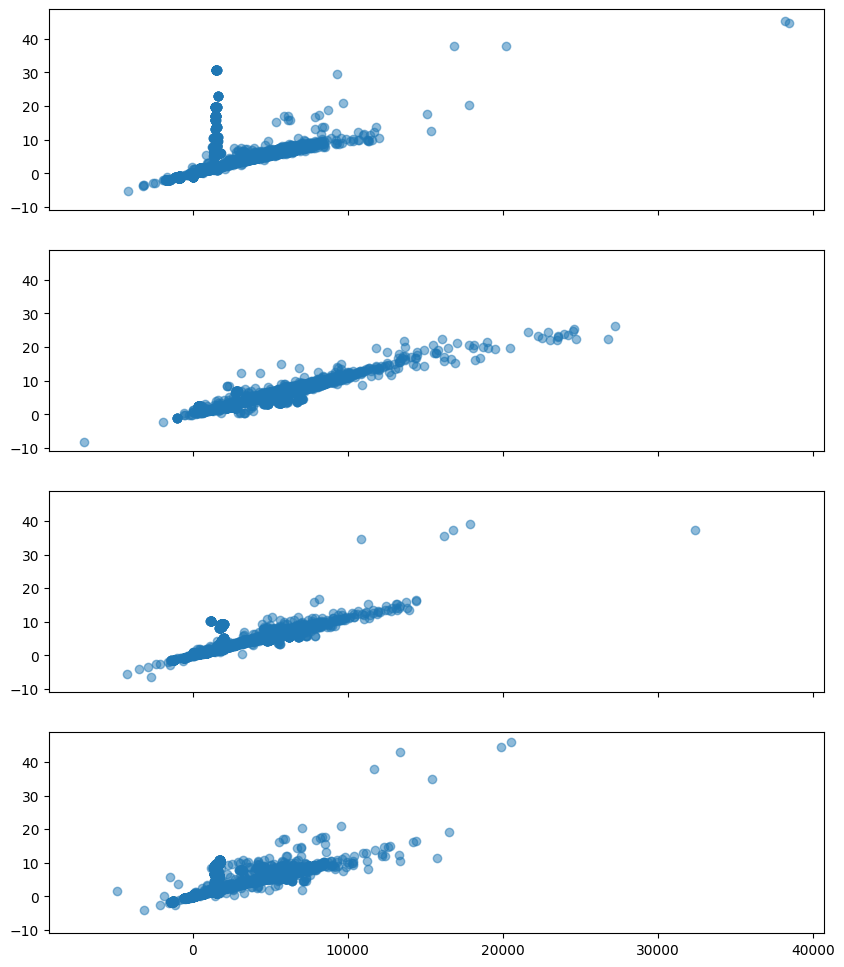

In [43]:
# --- Plot original data + line + outliers ---
fig , ax = plt.subplots(4,figsize=(10, 12),sharex=True, sharey=True)

ax[0].scatter(comp_df['FCU-2 thermal load'][~mask2], comp_df['FCU-2 Cooling Load_kW'][~mask2], alpha=0.5, label="Data points")
ax[1].scatter(comp_df['FCU-3 thermal load'][~mask3], comp_df['FCU-3 Cooling Load_kW'][~mask3], alpha=0.5, label="Data points")
ax[2].scatter(comp_df['FCU-4 thermal load'][~mask4], comp_df['FCU-4 Cooling Load_kW'][~mask4], alpha=0.5, label="Data points")
ax[3].scatter(comp_df['FCU-5 thermal load'][~mask5], comp_df['FCU-5 Cooling Load_kW'][~mask5], alpha=0.5, label="Data points")

In [ ]:
''' 
so now that the masks work, we can remove the faulty data points from the dataset, 
however we want to keep the values that dont have thermal load measurements
then we can replace as many missing power measurements as possible using the thermal load
'''

In [82]:
comp_df.loc[mask2, 'FCU-2 Cooling Load_kW'] = np.nan
comp_df.loc[mask3, 'FCU-3 Cooling Load_kW'] = np.nan
comp_df.loc[mask4, 'FCU-4 Cooling Load_kW'] = np.nan
comp_df.loc[mask5, 'FCU-5 Cooling Load_kW'] = np.nan

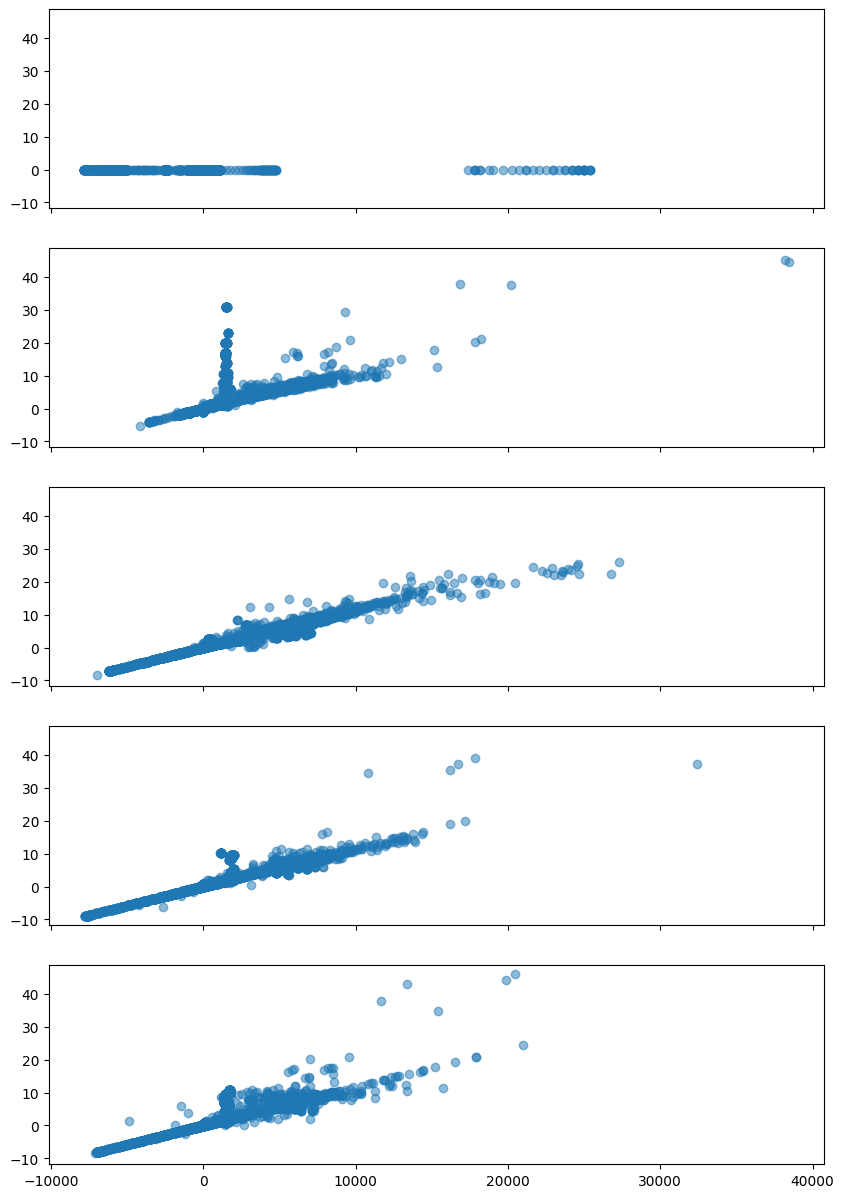

In [88]:
# --- Plot original data + line + outliers ---
fig , ax = plt.subplots(5,figsize=(10, 15),sharex=True, sharey=True)


# 1. Plot all data points
ax[0].scatter(comp_df['FCU-1 thermal load'], comp_df['FCU-1 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[1].scatter(comp_df['FCU-2 thermal load'], comp_df['FCU-2 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[2].scatter(comp_df['FCU-3 thermal load'], comp_df['FCU-3 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[3].scatter(comp_df['FCU-4 thermal load'], comp_df['FCU-4 Cooling Load_kW'], alpha=0.5, label="Data points")
ax[4].scatter(comp_df['FCU-5 thermal load'], comp_df['FCU-5 Cooling Load_kW'], alpha=0.5, label="Data points")


In [95]:
comp_df[headers].isnull().sum()

Timestamp                            0
FCU-1 Cooling Load_kW            38467
FCU-2 Cooling Load_kW            19065
FCU-3 Cooling Load_kW            19066
FCU-4 Cooling Load_kW            19070
FCU-5 Cooling Load_kW            19066
PFCU-1 Cooling Load_kW           19069
PFCU-2 Cooling Load_kW           19041
Outdoor Temperature             155309
Outdoor Temp Ave                246584
Outdoor Humidity                 45095
Wind Speed                       28927
Wind Direction                   30545
Solar Radiation                 150842
Zone 3 Temperature               18143
Zone 3  CO2                      18129
Zone 4 Temperature               18157
Zone 4 CO2                       18136
Zone 5 Temperature               18162
Zone 5 CO2 - S1                  18136
Zone 5 CO2 - S2                  18136
Zone 1 Temperature               18162
Zone 1  CO2 - S1                 18128
Zone 1  CO2 - S2                 18129
Zone 2 Temperature               18160
Zone 2 CO2               

In [94]:
'''
once cleared fill the data in
'''
comp_df.loc[comp_df['FCU-2 Cooling Load_kW'].isnull(),'FCU-2 Cooling Load_kW'] = comp_df.loc[comp_df['FCU-2 Cooling Load_kW'].isnull(),'FCU-2 thermal load']*0.0011666676000000001 
comp_df.loc[comp_df['FCU-3 Cooling Load_kW'].isnull(),'FCU-3 Cooling Load_kW'] = comp_df.loc[comp_df['FCU-3 Cooling Load_kW'].isnull(),'FCU-3 thermal load']*0.0011666676000000001 
comp_df.loc[comp_df['FCU-4 Cooling Load_kW'].isnull(),'FCU-4 Cooling Load_kW'] = comp_df.loc[comp_df['FCU-4 Cooling Load_kW'].isnull(),'FCU-4 thermal load']*0.0011666676000000001 
comp_df.loc[comp_df['FCU-5 Cooling Load_kW'].isnull(),'FCU-5 Cooling Load_kW'] = comp_df.loc[comp_df['FCU-5 Cooling Load_kW'].isnull(),'FCU-5 thermal load']*0.0011666676000000001 


In [51]:
'''
then save the data'''

284968

In [55]:
''' load both data sources and merge them together '''

nan

nan